\begin{center}
Brook Balkachew Nigatu
\end{center}

\hfill

**Github link**: https://github.com/Brook-B-Nigatu/TA_NLP-Final-Project
\newpage

# Executive Summary

## Project Objective

This project analyzes posts and comments from the r/Futurology subreddit to uncover underlying themes, sentiment trends, and named entities that characterize community discussion about future technologies, societal issues, and global challenges.

## Data Sources

- **Submissions:** 1000+ posts
- **Comments:** 10,000+ comments
- **Preprocessing:** Deduplication, removal of deleted/removed content, tokenization, lemmatization, and custom stop-word filtering

## Data Collection

- Used (Python/PRAW) to fetch new submissions and comments from r/Futurology at regular intervals

## Methodology

The analysis largely adheres to tidytext principles. Rows represent single tokens and metadata is stored in columns. This maximizes compatibility with tidyverse tools such as dplyr and ggplot2.

1. **Data Cleaning & Tokenization**

   - Combined posts and comments into a unified document corpus
   - Applied lemmatization with `textstem` and filtered out stop words, numeric tokens, URLs, and punctuation
   - Constructed a Document-Term Matrix (DTM) for topic modeling

2. **Topic Modeling (LDA)**

   - Tested multiple values of K (3, 5, 7, 9, 11)
   - Evaluated models using:
     - **Perplexity:** Measures how well a model predicts unseen data (lower values indicate better fit)
     - **Coherence:** Quantifies semantic consistency among top topic words (higher values indicate more interpretable topics)
   - Normalized and combined both metrics to select **K = 7** as the optimal number of topics
   - Extracted top 10 words per topic to interpret thematic content

3. **Sentiment Analysis**

   - Applied three lexicons/methods:
     1. **Bing:** Word-level positive/negative classification
     2. **AFINN:** Word-level sentiment values (−5 to +5)
     3. **VADER:** Document-level compound scores, capturing negation and intensity
   - Summarized mean/median sentiment per topic and compared methods side-by-side

4. **Named Entity Recognition (NER)**
   - Utilized `spacyr` with the `en_core_web_sm` model
   - Identified and filtered entities (PERSON, ORG, GPE, etc.)
   - Calculated the top entities by frequency per topic and analyzed distribution of entity types
\newpage

# Introduction

## About r/Futurology

r/Futurology is a popular subreddit for forward-thinking discussion and speculation on emerging technologies, scientific breakthroughs, and societal trends. With tens of thousands of members, the community shares news, research, and debates about how innovation will shape the future.

## Key Algorithms & Methods

- **Tokenization & Lemmatization**  
  Breaks raw text into individual tokens (words) and reduces each to its base (lemma) form. This normalization helps group similar terms (e.g., “running” → “run”) and simplifies the vocabulary for modeling.

- **Document–Term Matrix (DTM)**  
  Represents the corpus as a sparse numerical matrix where rows are documents and columns are terms. The DTM captures term frequency information, enabling statistical and machine-learning algorithms to process textual data.

- **Latent Dirichlet Allocation (LDA)**  
  A generative probabilistic model that discovers latent topics in a document collection. It assumes each document is a mixture of topics and each topic is a distribution over words. LDA reveals thematic structures by estimating:

  - Topic–word distributions: the probability of each word in a topic
  - Document–topic distributions: the probability of each topic in a document

- **Sentiment Analysis**  
  Assesses the emotional tone of text using:

  1. **Lexicon-based methods** (Bing, AFINN): assign pre-defined sentiment scores or positive/negative labels to individual words, then aggregate at document or topic level.
  2. **VADER** (Valence Aware Dictionary and sEntiment Reasoner): a rule-based model optimized for social media, providing compound scores that capture negations, intensifiers, and punctuation-based emphasis.

- **Named Entity Recognition (NER)**  
  Identifies and classifies real-world entities (e.g., people, organizations, geographic locations) within text. Using `spacyr` (spaCy’s R interface), NER extracts structured information that can be analyzed across topics.

- **LDA Model Evaluation Metrics**
  - **Perplexity:** measures how well a probabilistic model predicts unseen data (lower perplexity indicates a better statistical fit).
  - **Coherence:** evaluates the semantic consistency of top words within topics based on co-occurrence statistics (higher coherence aligns with more interpretable topics).
\newpage

# Methodology and Results

## Install and Load Required Packages

This section installs and loads all necessary R packages for text analysis, topic modeling, sentiment analysis, and visualization. We ensure all dependencies are properly managed and packages are available before proceeding with the analysis.

In [24]:
suppressWarnings({# Script Start: Install and Load Required Packages
if (getOption("repos")["CRAN"] == "@CRAN@") {
  options(repos = c(CRAN = "https://cran.rstudio.com/"))
}

# List of required packages
required_packages <- c(
  "tidyverse", 
  "tidytext", 
  "topicmodels", 
  "tm", 
  "textdata", 
  "ggplot2", 
  "wordcloud", 
  "RColorBrewer", 
  "dplyr",       
  "stringr",     
  "broom",
  "textstem",    
  "reshape2",    
  "gridExtra",   
  "devtools",    
  "spacyr"       
)

# Check if packages are installed, install if not
for (pkg in required_packages) {
  if (!requireNamespace(pkg, quietly = TRUE)) {
    install.packages(pkg, dependencies = TRUE)
  }
}

suppressPackageStartupMessages({
  library(tidyverse)
  library(tidytext)
  library(topicmodels)
  library(tm)
  library(textdata)
  library(ggplot2)
  library(wordcloud)
  library(RColorBrewer)
  library(dplyr)
  library(stringr)
  library(broom)
  library(textstem)
  library(reshape2)
  library(gridExtra)
})})

## Load Data

Here we load the Reddit submissions and comments datasets. The data consists of posts and comments from the r/Futurology subreddit, which focuses on discussions about future technology, science, and society.

In [2]:
# Set working directory
# setwd("c:/Users/brook/Desktop/Courses/Year 1/Sem 2/Text Analysis/Project")

# Load data
print("Loading data...")
submissions <- read.csv("futurology_submissions.csv", stringsAsFactors = FALSE)
comments <- read.csv("futurology_comments.csv", stringsAsFactors = FALSE)

print(paste("Loaded", nrow(submissions), "submissions and", nrow(comments), "comments"))

[1] "Loading data..."
[1] "Loaded 1060 submissions and 12038 comments"


## Data Preprocessing

### Submissions (Posts)

- **Filtering:**
  - Removes rows where `body` is NA, empty, `[deleted]`, or `[removed]`.
- **Selection:**
  - Selects columns: `id`, `title`, `body`, `author`, `created_utc`.
- **Text Construction:**
  - Concatenates `title` and `body` into a new `text` column.
- **Metadata:**
  - Adds `document_type = "submission"` and a unique `document_id` prefixed with `sub_`.
- **Final Columns:**
  - Keeps: `document_id`, `text`, `document_type`, `author`, `created_utc`.

### Comments

- **Filtering:**
  - Removes rows where `body` is NA, empty, `[deleted]`, or `[removed]`.
- **Selection:**
  - Selects columns: `id`, `body`, `author`, `created_utc`, `submission_id`.
- **Text Construction:**
  - Uses `body` as the `text` column.
- **Metadata:**
  - Adds `document_type = "comment"` and a unique `document_id` prefixed with `com_`.
- **Final Columns:**
  - Keeps: `document_id`, `text`, `document_type`, `author`, `created_utc`.

### Combine Documents

- **Binding:**
  - Combines cleaned submissions and comments into a single data frame `all_documents`.


### Why Combine Posts and Comments into a Single “Document”?

When we treat each Reddit submission (post) and each comment as its own document in the corpus, we capture both the initiator’s framing of a topic and the community’s follow-on discussion. Combining them in this way offers several benefits:

1. Holistic Context  
   • Posts often introduce a question, claim, or news item, while comments elaborate, debate, and clarify. Modeling them together ensures topics reflect the full conversation rather than only one side.

2. Enhanced Topic Coherence  
   • Comments typically contain terms and arguments that complement the original post. Including both boosts co-occurrence counts for related words, which improves the semantic coherence of the topics discovered.

3. Balanced Representation  
   • Reddit threads vary in comment depth—some posts attract extensive discussion, others very little. Treating each comment as its own document prevents long threads from dominating topic proportions and keeps the model from over-weighting highly active posts.

4. Simplified Workflow  
   • From a preprocessing standpoint, assigning every unit of text (post or comment) a unique document ID and treating them identically makes the pipeline more uniform—one DTM, one LDA run, one set of evaluation metrics.

By considering posts and comments on equal footing, our LDA model uncovers richer, more nuanced themes that mirror both the prompt and the reaction in r/Futurology discussions.

In [3]:
# Combine posts and submissions (treat each post body and each comment as one document)

# Prepare submissions data
submissions_clean <- submissions %>%
  filter(!is.na(body) & body != "" & body != "[deleted]" & body != "[removed]") %>%
  select(id, title, body, author, created_utc) %>%
  mutate(
    text = paste(title, body, sep = " "),
    document_type = "submission",
    document_id = paste0("sub_", id)
  ) %>%
  select(document_id, text, document_type, author, created_utc)

# Prepare comments data
comments_clean <- comments %>%
  filter(!is.na(body) & body != "" & body != "[deleted]" & body != "[removed]") %>%
  select(id, body, author, created_utc, submission_id) %>%
  mutate(
    text = body,
    document_type = "comment",
    document_id = paste0("com_", id)
  ) %>%
  select(document_id, text, document_type, author, created_utc)

# Combine all documents
all_documents <- bind_rows(submissions_clean, comments_clean)
print(paste("Total documents:", nrow(all_documents)))

[1] "Total documents: 12528"


## Text Preprocessing and Cleaning

### Stop Words

- **Custom Stop Words:**
  - Combines standard English stop words with additional Reddit-specific and common filler words (e.g., "reddit", "subreddit", "post", "thing", "really", etc.).

### Tokenization & Lemmatization

- **Tokenization:**
  - Splits text into individual words (tokens) using `unnest_tokens`.
- **Cleaning Tokens:**
  - Removes tokens that are:
    - Pure numbers
    - URLs (tokens starting with `http` or `https`)
    - Non-alphabetic words (tokens not starting with a-z)
- **Lemmatization:**
  - Applies lemmatization to each word (reducing words to their base form).
- **Stop Word Removal:**
  - Removes tokens that are in the custom stop words list (after lemmatization).

In [4]:
# Remove stop words and tokenize

# Create custom stop words (combining standard English stop words with common Reddit terms)
custom_stop_words <- bind_rows(
  stop_words,
  tibble(word = c("reddit", "sub", "subreddit", "post", "comment", "edit", "update", 
                  "deleted", "removed", "nbsp", "http", "https", "www", "com",
                  "people", "thing", "things", "lot", "bit", "kind", "sort",
                  "pretty", "really", "actually", "basically", "literally"),
         lexicon = "custom")
)

# Tokenize, lemmatize, and clean text
tidy_documents <- all_documents %>%
  unnest_tokens(word, text) %>%
  filter(
    !str_detect(word, "^[0-9]+$"),  # Remove pure numbers
    !str_detect(word, "^https?"),   # Remove URLs
    !str_detect(word, "^[^a-z]")    # Remove non-alphabetic words
  ) %>%
  mutate(word_lemma = lemmatize_words(word)) %>%  # Add lemmatization step
  anti_join(custom_stop_words) # %>%  # Remove stop words after lemmatization

print(paste("Total tokens after cleaning:", nrow(tidy_documents)))

Joining with `by = join_by(word)`


[1] "Total tokens after cleaning: 268810"


## Document-Term Matrix Creation

We create a Document-Term Matrix (DTM), which is a mathematical representation where:
- **Rows** represent documents (posts/comments)
- **Columns** represent unique terms (lemmatized words)
- **Values** represent term frequencies within each document

This matrix structure is required for topic modeling algorithms like Latent Dirichlet Allocation (LDA).

In [5]:
# Create document-term matrix for topic modeling

# Count words per document
doc_word_counts <- tidy_documents %>%
  count(document_id, word_lemma, sort = TRUE)

# Create document-term matrix
dtm <- doc_word_counts %>%
  cast_dtm(document_id, word_lemma, n)

print(paste("DTM dimensions:", nrow(dtm), "x", ncol(dtm)))

[1] "DTM dimensions: 12434 x 19647"


## Topic Modeling

Topic modeling uses **Latent Dirichlet Allocation (LDA)** to discover hidden thematic structures in the text.

### Understanding Latent Dirichlet Allocation (LDA)

#### What is LDA?

Latent Dirichlet Allocation (LDA) is a generative probabilistic model used for topic modeling, where the goal is to discover latent (hidden) topics in a collection of documents. It assumes:

- Each document is a mixture of topics.
- Each topic is a distribution over words.

Training an LDA model gives us:

1. **Topic–word distributions** (which words are most likely under each topic).
2. **Document–topic distributions** (which topics are most prominent in each document).

Based on this we can classify documents into topics. Naturally, to each document, we assign the most likely topic within that document.

We can also get some interpretability of the topics by examining the top (i.e most probable) words within that topic according to the learned distributions.

#### Choosing the Number of Topics

The number of topics (K) is a hyperparameter that determines how many distinct thematic groups the model will learn. Selecting K is critical: too few topics can merge distinct themes, while too many can split coherent themes into smaller, less interpretable subtopics. To find an optimal K, the script tests multiple values (e.g., 3, 5, 7, 9, 11) and evaluates each model using:

- **Perplexity**: a likelihood-based measure of model fit to the data. Lower perplexity indicates the model better predicts unseen documents, but it can favor more complex models (larger K) and may not align with human interpretability.

- **Coherence**: measures the degree of semantic similarity among the top words in each topic by computing word co-occurrence statistics in the corpus. Higher coherence scores correlate with more interpretable and semantically cohesive topics. Since coherence scores are negative, these are the scores closer to 0.

In [6]:

calculate_perplexity <- function(lda_model, dtm) {
  perplexity(lda_model, dtm)
}

# Function to calculate coherence score
calculate_coherence <- function(lda_model, dtm, top_n = 10) {
  # Extract top terms for each topic
  topics_terms <- tidy(lda_model, matrix = "beta") %>%
    group_by(topic) %>%
    slice_max(beta, n = top_n) %>%
    ungroup()
  
  # Calculate coherence using word co-occurrence
  coherence_scores <- numeric(length(unique(topics_terms$topic)))
  
  for (topic_num in unique(topics_terms$topic)) {
    topic_words <- topics_terms %>%
      filter(topic == topic_num) %>%
      pull(term)
    
    # Calculate pairwise coherence
    coherence_sum <- 0
    pair_count <- 0
    
    for (i in 1:(length(topic_words)-1)) {
      for (j in (i+1):length(topic_words)) {
        word1 <- topic_words[i]
        word2 <- topic_words[j]
        
        # Count documents containing both words
        docs_with_both <- sum(as.vector(dtm[, word1] > 0) & as.vector(dtm[, word2] > 0))
        docs_with_word1 <- sum(as.vector(dtm[, word1] > 0))
        
        if (docs_with_word1 > 0) {
          coherence_sum <- coherence_sum + log((docs_with_both + 1) / docs_with_word1)
          pair_count <- pair_count + 1
        }
      }
    }
    
    coherence_scores[topic_num] <- if (pair_count > 0) coherence_sum / pair_count else 0
  }
  
  return(mean(coherence_scores))
}

## Evaluation of Topic Models

We try different values for the number of topics (3, 5, 7, 9, and 11), and choose the one based on perplexity and coherence scores.  

Both metrics are normalized to a 0–1 scale and combined equally to form a **combined score**:

```r
normalized_perplexity <- (max(perplexity_scores) - perplexity_scores) /
                         (max(perplexity_scores) - min(perplexity_scores))
normalized_coherence  <- (coherence_scores - min(coherence_scores)) /
                         (max(coherence_scores) - min(coherence_scores))
combined_scores       <- (normalized_perplexity + normalized_coherence) / 2
```

Note that the normalization takes into account the fact that we desire lower perplexity scores by taking the negative of the perplexity scores.

The model with the highest combined score is selected as the optimal topic count.

In [7]:
# Test different numbers of topics
k_values <- c(3, 5, 7, 9, 11)

topic_models <- list()
perplexity_scores <- numeric(length(k_values))
coherence_scores <- numeric(length(k_values))

for (i in seq_along(k_values)) {
  k <- k_values[i]
  
  set.seed(123)  # For reproducibility
  lda_model <- LDA(dtm, k = k, control = list(alpha = 0.1, seed = 123))
  
  topic_models[[i]] <- lda_model
  perplexity_scores[i] <- calculate_perplexity(lda_model, dtm)
  coherence_scores[i] <- calculate_coherence(lda_model, dtm)
}

# Normalize scores for comparison (higher is better for both after normalization)
# For perplexity, we want lower values, so we invert the ranking
normalized_perplexity <- (max(perplexity_scores) - perplexity_scores) / (max(perplexity_scores) - min(perplexity_scores))
# For coherence, higher is already better
normalized_coherence <- (coherence_scores - min(coherence_scores)) / (max(coherence_scores) - min(coherence_scores))

# Combined score (equal weighting)
combined_scores <- (normalized_perplexity + normalized_coherence) / 2

# Choose optimal number of topics based on combined score
optimal_k_index <- which.max(combined_scores)
optimal_k <- k_values[optimal_k_index]
optimal_model <- topic_models[[optimal_k_index]]

print(paste("Optimal number of topics (combined metric):", optimal_k))

[1] "Optimal number of topics (combined metric): 7"


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


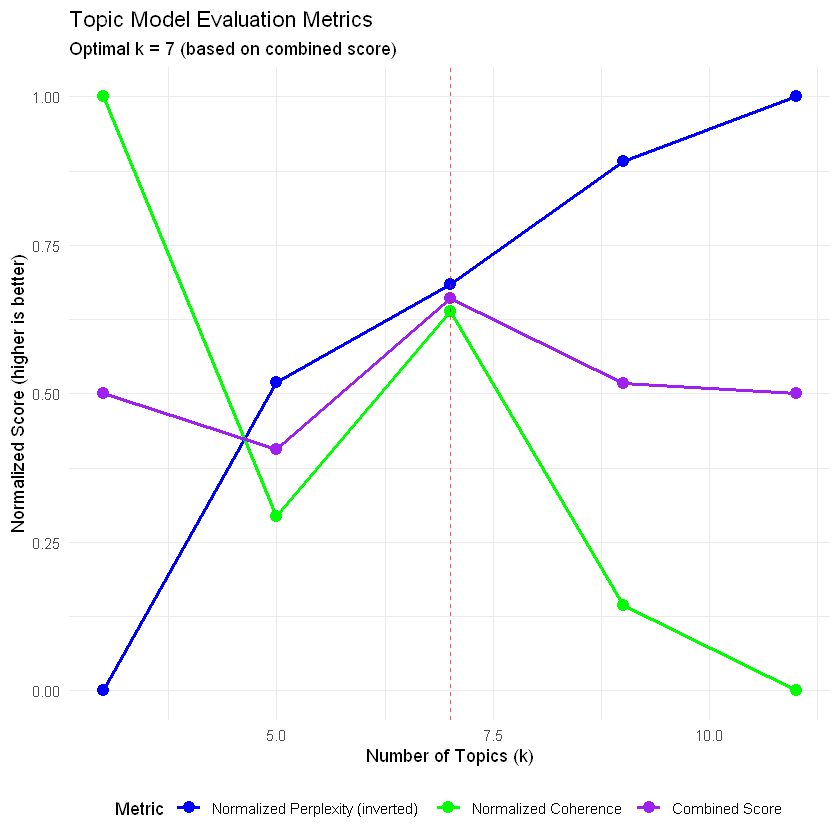

In [8]:
# Create comprehensive evaluation dataframe
evaluation_df <- data.frame(
  k = k_values,
  perplexity = perplexity_scores,
  coherence = coherence_scores,
  normalized_perplexity = normalized_perplexity,
  normalized_coherence = normalized_coherence,
  combined_score = combined_scores
)

# Plot all metrics
library(reshape2)
metrics_long <- evaluation_df %>%
  select(k, normalized_perplexity, normalized_coherence, combined_score) %>%
  melt(id.vars = "k", variable.name = "metric", value.name = "score")

ggplot(metrics_long, aes(x = k, y = score, color = metric)) +
  geom_line(size = 1) +
  geom_point(size = 3) +
  geom_vline(xintercept = optimal_k, color = "red", linetype = "dashed", alpha = 0.7) +
  scale_color_manual(values = c("blue", "green", "purple"),
                     labels = c("Normalized Perplexity (inverted)", "Normalized Coherence", "Combined Score")) +
  labs(title = "Topic Model Evaluation Metrics",
       subtitle = paste("Optimal k =", optimal_k, "(based on combined score)"),
       x = "Number of Topics (k)",
       y = "Normalized Score (higher is better)",
       color = "Metric") +
  theme_minimal() +
  theme(legend.position = "bottom")

In this analysis, the script identified **K = 7** as the best balance between model fit and interpretability.

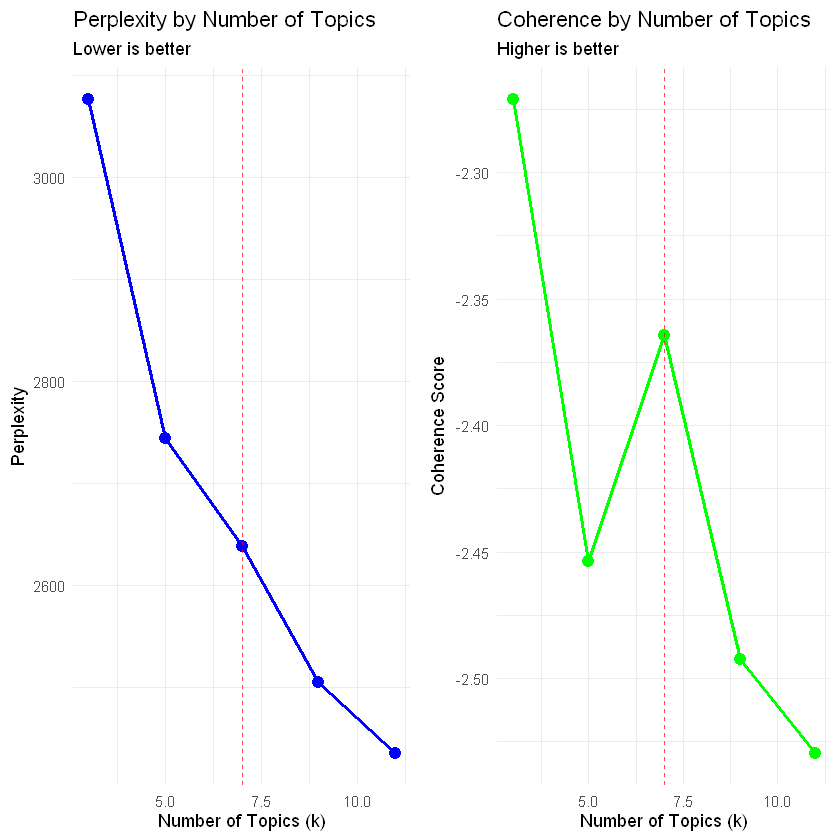

In [9]:
# Individual plots for detailed view
# Perplexity plot
perplexity_df <- data.frame(k = k_values, perplexity = perplexity_scores)
p1 <- ggplot(perplexity_df, aes(x = k, y = perplexity)) +
  geom_line(color = "blue", size = 1) +
  geom_point(color = "blue", size = 3) +
  geom_vline(xintercept = optimal_k, color = "red", linetype = "dashed", alpha = 0.7) +
  labs(title = "Perplexity by Number of Topics",
       subtitle = "Lower is better",
       x = "Number of Topics (k)",
       y = "Perplexity") +
  theme_minimal()

# Coherence plot
coherence_df <- data.frame(k = k_values, coherence = coherence_scores)
p2 <- ggplot(coherence_df, aes(x = k, y = coherence)) +
  geom_line(color = "green", size = 1) +
  geom_point(color = "green", size = 3) +
  geom_vline(xintercept = optimal_k, color = "red", linetype = "dashed", alpha = 0.7) +
  labs(title = "Coherence by Number of Topics",
       subtitle = "Higher is better",
       x = "Number of Topics (k)",
       y = "Coherence Score") +
  theme_minimal()

# Combine plots
library(gridExtra)
combined_plot <- grid.arrange(p1, p2, ncol = 2)

## Document Assignments and Topic Analysis

Using the optimal topic model, we:
- **Assign each document** to its most likely topic based on probability distributions
- **Analyze topic distributions** to understand how documents are distributed across topics
- **Extract top words** for each topic to understand their thematic content
- **Create visualizations** including word clouds and bar charts

This provides interpretable insights into the main themes present in r/Futurology discussions.

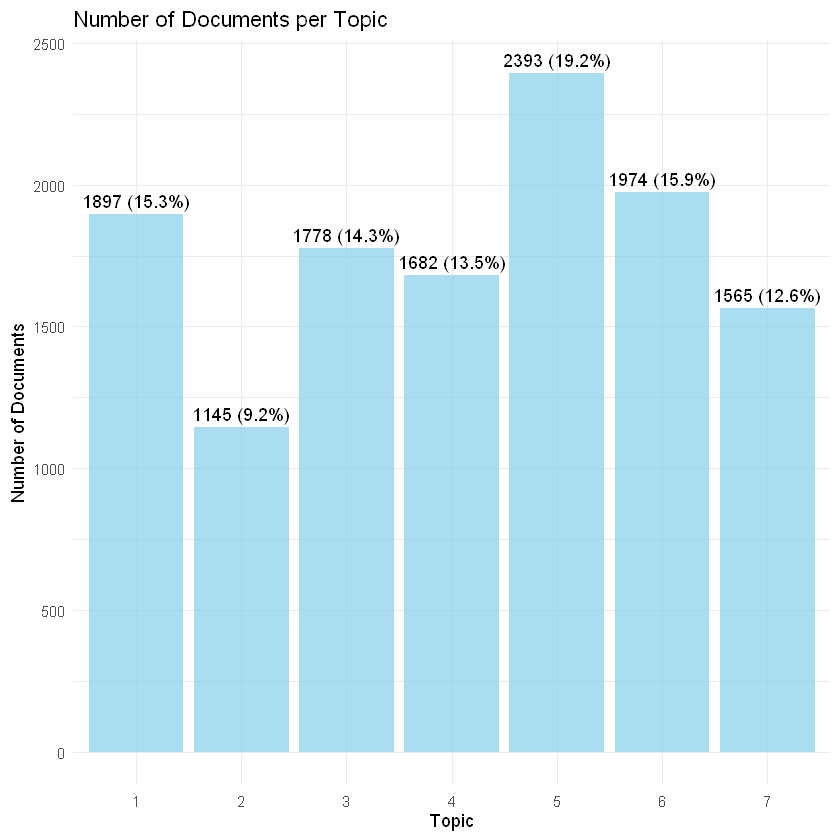

In [10]:
# Document assignments and topic analysis

# Get document-topic probabilities
doc_topics <- tidy(optimal_model, matrix = "gamma")

# Get the most likely topic for each document
doc_topic_assignments <- doc_topics %>%
  group_by(document) %>%
  slice_max(gamma, n = 1, with_ties = FALSE) %>%
  ungroup()

# Count documents per topic
documents_per_topic <- doc_topic_assignments %>%
  count(topic, sort = TRUE) %>%
  mutate(percentage = round(n / sum(n) * 100, 1))

# Visualize documents per topic
ggplot(documents_per_topic, aes(x = factor(topic), y = n)) +
  geom_col(fill = "skyblue", alpha = 0.7) +
  geom_text(aes(label = paste0(n, " (", percentage, "%)"), vjust = -0.5)) +
  labs(title = "Number of Documents per Topic",
       x = "Topic",
       y = "Number of Documents") +
  theme_minimal()

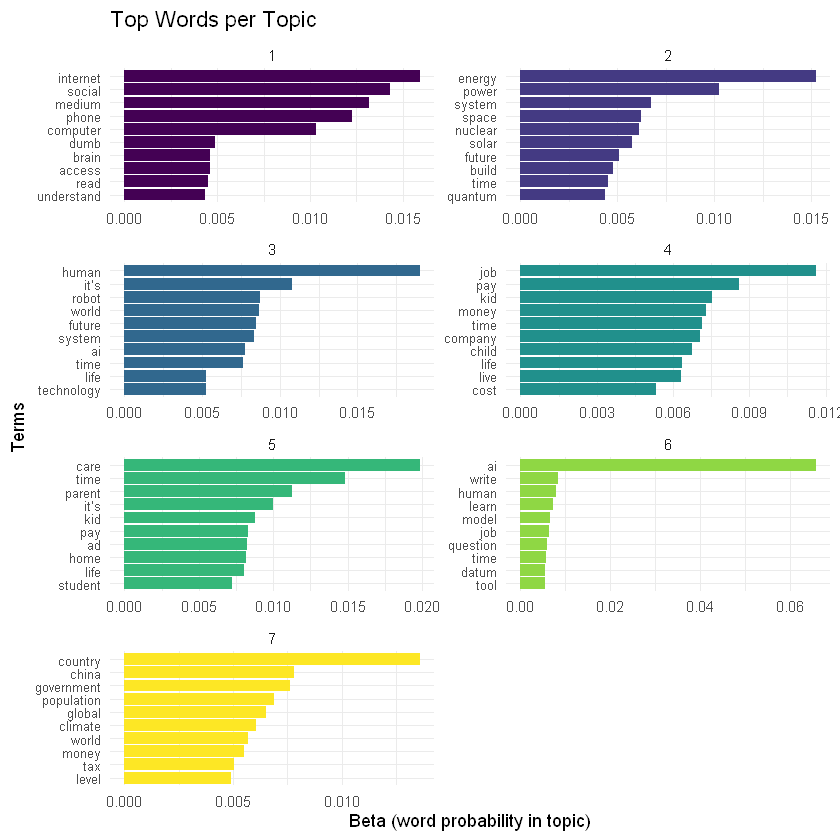

In [11]:
# Most likely words per topic
topic_terms <- tidy(optimal_model, matrix = "beta") %>%
  group_by(topic) %>%
  slice_max(beta, n = 10) %>%
  ungroup() %>%
  arrange(topic, -beta)

# Visualize top words per topic
ggplot(topic_terms, aes(x = reorder_within(term, beta, topic), y = beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free", ncol = 2) +
  coord_flip() +
  scale_x_reordered() +
  scale_fill_viridis_d() +
  labs(title = "Top Words per Topic",
       x = "Terms",
       y = "Beta (word probability in topic)") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 8))

### Interpreting Topics from r/Futurology Analysis

Below are the 7 topics extracted by fitting an LDA model to Reddit posts and comments from r/Futurology. For each topic, we list the top 10 words (by β probability) and provide a brief interpretation.

**Topic 1: Digital Access & Information**

**Top terms:** internet, social, medium, phone, computer, dumb, brain, access, read, understand

This topic centers on digital connectivity and how people consume and process information online. Keywords like **internet**, **social**, **phone**, and **computer** point to discussions about platforms and devices, while words such as **read**, **understand**, and **brain** suggest concern with comprehension and the impact of digital media on cognition.

**Topic 2: Energy & Power Systems**

**Top terms:** energy, power, system, space, nuclear, solar, future, build, time, quantum

This theme covers energy technologies and infrastructure. With terms like **energy**, **power**, **nuclear**, and **solar**, conversations likely focus on generation methods. References to **space** and **quantum** hint at emerging or speculative technologies (e.g., space-based solar power or quantum energy systems) driving future innovation.

**Topic 3: Human–Machine Interaction & AI**

**Top terms:** human, it’s, robot, world, future, system, ai, time, life, technology

Topic 3 reflects the intersection of humans with robotics and artificial intelligence. Words like **robot**, **ai**, and **technology** show interest in automation, while **human**, **life**, and **world** indicate discussions about societal and ethical implications as AI shapes our future.

**Topic 4: Work & Economic Conditions**

**Top terms:** job, pay, kid, money, time, company, child, life, live, cost

This topic groups threads about employment, wages, and the cost of living. **job**, **pay**, **cost**, and **money** point to economic concerns. The presence of **kid** and **child** suggests discussions around family finances, childcare, and balancing work with personal life.

**Topic 5: Care & Work–Life Balance**

**Top terms:** care, time, parent, it’s, kid, pay, ad, home, life, student

Closely related to Topic 4, Topic 5 emphasizes caregiving and personal roles. **care**, **parent**, **home**, and **student** bring in aspects of education, health, and domestic life, highlighting how future trends affect both professional and personal responsibilities.

**Topic 6: AI Tools & Models**

**Top terms:** ai, write, human, learn, model, job, question, time, datum, tool

This topic zeroes in on specific AI-driven tools, with **ai**, **model**, and **tool** at the forefront. Words like **write**, **learn**, and **question** suggest applications in natural language generation and machine learning for tasks such as content creation, study aids, and data analysis.

**Topic 7: Geopolitics & Global Issues**

**Top terms:** country, china, government, population, global, climate, world, money, tax, level

Topic 7 deals with macro-scale society and governance. With **country**, **government**, **population**, and **tax**, users debate policy, demographics, and economic systems. Inclusion of **climate** and **global** reflects environmental and geopolitical concerns in an interconnected world.

Warning message in wordcloud(words = topic_words$term, freq = topic_words$beta, :
"phone could not be fit on page. It will not be plotted."
Warning message in wordcloud(words = topic_words$term, freq = topic_words$beta, :
"computer could not be fit on page. It will not be plotted."


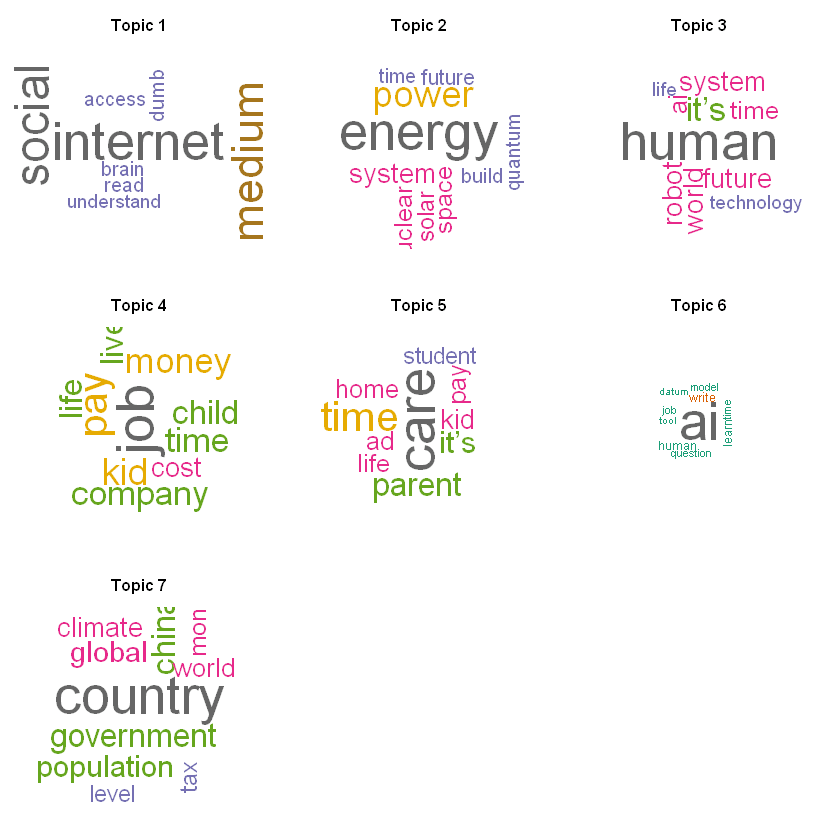

In [23]:
# Create word clouds and display them in a grid
library(gridExtra)

# Calculate grid dimensions
ncol_grid <- 3  # Number of columns for the grid
nrow_grid <- ceiling(optimal_k / ncol_grid)

# Set up plotting parameters for the grid display
par(mfrow = c(nrow_grid, ncol_grid), mar = c(2, 2, 3, 2))

for (t in 1:optimal_k) {
  topic_words <- topic_terms %>%
    filter(topic == t)
  
  wordcloud(words = topic_words$term, 
            freq = topic_words$beta,
            min.freq = 1,
            max.words = 100,
            random.order = FALSE,
            rot.per = 0.35,
            colors = brewer.pal(8, "Dark2"))
  title(paste("Topic", t), cex.main = 1.2)
}

# dev.off()
par(mfrow = c(1, 1))

## Sentiment Analysis

We perform comprehensive sentiment analysis using three different approaches:

### Bing Lexicon

**Bing** is a simple lexicon-based method that classifies words as either _positive_ or _negative_. It uses a curated list of terms tagged with binary sentiment labels.

- **Approach**:

  - Each word in the text is looked up in the Bing lexicon.
  - Words tagged as _positive_ or _negative_ are counted.
  - Overall sentiment can be expressed as the difference or ratio of positive and negative word counts.


### AFINN Lexicon

**AFINN** is a lexicon-based method that assigns each word an integer sentiment score ranging from -5 to +5. Negative scores indicate negative sentiment, positive scores indicate positive sentiment, and magnitude represents intensity.

- **Approach**:

  - Each token is matched to its AFINN score.
  - Aggregate statistics (mean, median, sum) of the scores provide sentiment measures for documents or clusters.

### VADER (Valence Aware Dictionary and sEntiment Reasoner)

**VADER** is a rule-based model specifically tuned for social media text. It accounts for context, including negations, intensifiers, punctuation emphasis, capitalization, and emoji.

- **Approach**:

  - Tokenize sentences and apply lexicon scores with rules for:
    - **Negation handling** (e.g., "not good" flips positive score).
    - **Intensity modifiers** (e.g., "extremely" amplifies sentiment).
    - **Punctuation emphasis** (e.g., exclamation marks increase intensity).
  - Produces four normalized scores:
    - `pos`, `neu`, `neg`: proportions of text carrying each polarity.
    - `compound`: normalized aggregate score ranging from -1 (most negative) to +1 (most positive).


We analyze sentiment patterns within each topic to understand the emotional tone of different discussion themes.

In [13]:
# Sentiment analysis within each topic

bing_sentiments <- readRDS("bing_lexicon.rds")
afinn_sentiments <- readRDS("afinn_lexicon.rds")

doc_topic_assignments <- doc_topics %>%
  group_by(document) %>%
  slice_max(gamma, n = 1, with_ties = FALSE) %>%
  ungroup()

# Add topic information to tidy_documents
tidy_documents_with_topics <- tidy_documents %>%
  left_join(doc_topic_assignments, by = c("document_id" = "document")) %>%
  filter(!is.na(topic))

# Sentiment analysis using bing lexicon
sentiment_by_topic <- tidy_documents_with_topics %>%
  inner_join(bing_sentiments, by = "word") %>%
  count(topic, sentiment) %>%
  pivot_wider(names_from = sentiment, values_from = n, values_fill = 0) %>%
  mutate(sentiment_score = (positive - negative) / (positive + negative))

# AFINN sentiment scores
afinn_by_topic <- tidy_documents_with_topics %>%
  inner_join(afinn_sentiments, by = "word") %>%
  group_by(topic) %>%
  summarise(
    mean_sentiment = mean(value, na.rm = TRUE),
    median_sentiment = median(value, na.rm = TRUE),
    total_words = n(),
    .groups = "drop"
  )

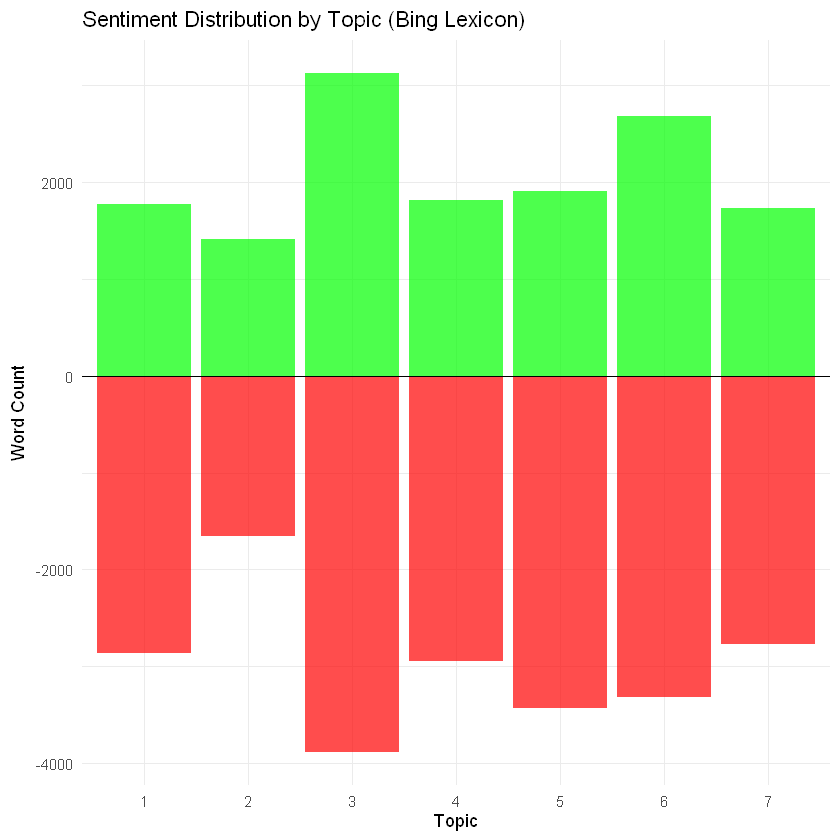

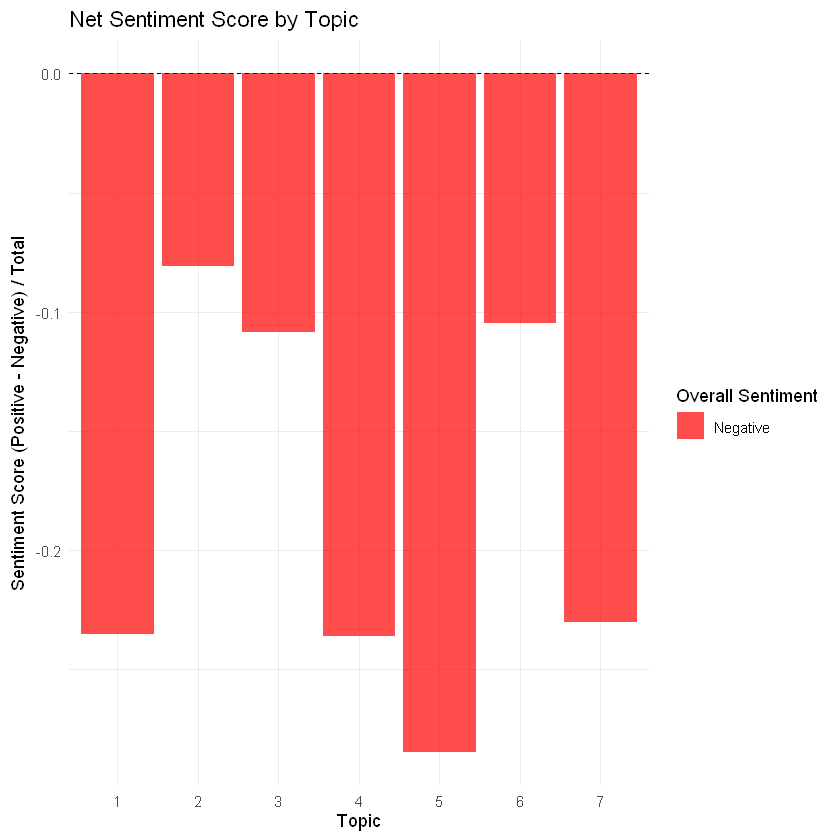

In [14]:
# Visualize sentiment by topic (Bing lexicon)
ggplot(sentiment_by_topic, aes(x = factor(topic))) +
  geom_col(aes(y = positive), fill = "green", alpha = 0.7, position = "identity") +
  geom_col(aes(y = -negative), fill = "red", alpha = 0.7, position = "identity") +
  geom_hline(yintercept = 0, color = "black") +
  labs(title = "Sentiment Distribution by Topic (Bing Lexicon)",
       x = "Topic",
       y = "Word Count") +
  theme_minimal()


# Net sentiment plot
ggplot(sentiment_by_topic, aes(x = factor(topic), y = sentiment_score)) +
  geom_col(aes(fill = sentiment_score > 0), alpha = 0.7) +
  scale_fill_manual(values = c("red", "green"), 
                    labels = c("Negative", "Positive"),
                    name = "Overall Sentiment") +
  geom_hline(yintercept = 0, color = "black", linetype = "dashed") +
  labs(title = "Net Sentiment Score by Topic",
       x = "Topic",
       y = "Sentiment Score (Positive - Negative) / Total") +
  theme_minimal()

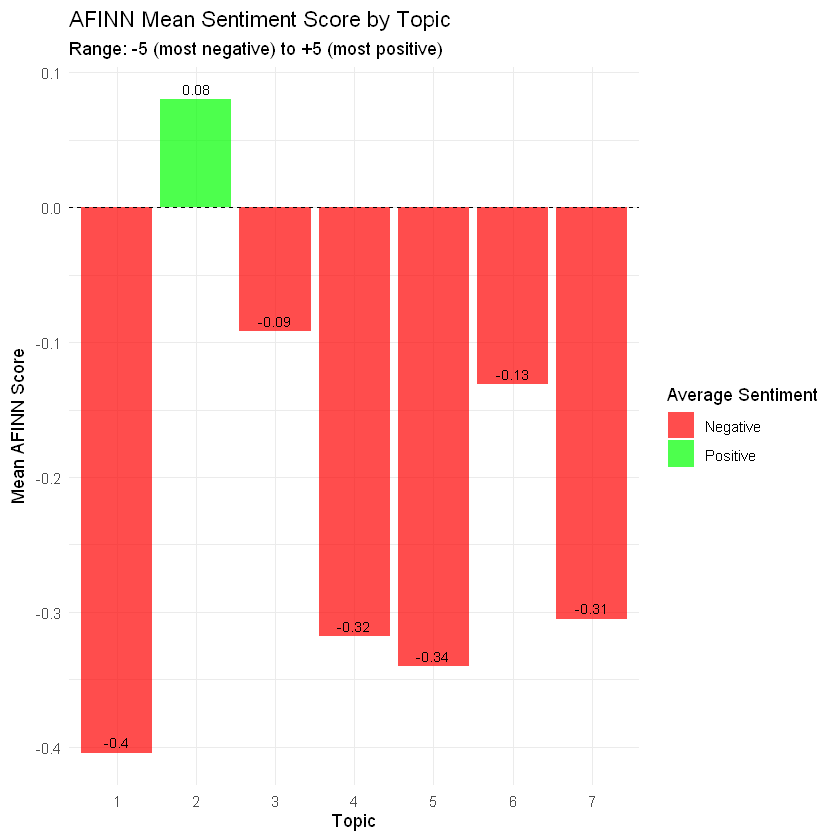

In [15]:
# Visualize AFINN sentiment by topic
ggplot(afinn_by_topic, aes(x = factor(topic), y = mean_sentiment)) +
  geom_col(aes(fill = mean_sentiment > 0), alpha = 0.7) +
  scale_fill_manual(values = c("red", "green"), 
                    labels = c("Negative", "Positive"),
                    name = "Average Sentiment") +
  geom_hline(yintercept = 0, color = "black", linetype = "dashed") +
  geom_text(aes(label = round(mean_sentiment, 2)), vjust = -0.5, size = 3) +
  labs(title = "AFINN Mean Sentiment Score by Topic",
       subtitle = "Range: -5 (most negative) to +5 (most positive)",
       x = "Topic",
       y = "Mean AFINN Score") +
  theme_minimal()

The analyses with both the Bing and AFINN lexicons suggest that sentiments are negative on average across most of the topics. However, the analysis with the AFINN lexicon reports a slightly positive overall sentiment on topic 2, which is about energy technologies.

In [16]:
# Install and load tidyvader package
if (!requireNamespace("tidyvader", quietly = TRUE)) {
  if (!requireNamespace("devtools", quietly = TRUE)) {
    install.packages("devtools")
  }
  devtools::install_github("chris31415926535/tidyvader")
}

library(tidyvader)


# First, we need to reconstruct the original text for each document to use VADER
documents_for_vader <- all_documents %>%
  left_join(doc_topic_assignments, by = c("document_id" = "document")) %>%
  filter(!is.na(topic)) %>% 
  mutate(
    clean_text = str_squish(text) 
  ) %>%
  filter(nchar(clean_text) > 0) %>% 
  select(document_id, topic, clean_text) 

vader_augmented_df <- tidyvader::vader(documents_for_vader, clean_text)

vader_results <- vader_augmented_df %>%
  select(document_id, topic, compound, pos, neu, neg) %>% 
  mutate(
    compound = as.numeric(compound),
    pos = as.numeric(pos),
    neu = as.numeric(neu),
    neg = as.numeric(neg)
  )

In [17]:
# Summarize VADER sentiment by topic
vader_by_topic <- vader_results %>%
  group_by(topic) %>%
  summarise(
    mean_compound = mean(compound, na.rm = TRUE),
    median_compound = median(compound, na.rm = TRUE),
    mean_positive = mean(pos, na.rm = TRUE),
    mean_neutral = mean(neu, na.rm = TRUE),
    mean_negative = mean(neg, na.rm = TRUE),
    # Classify overall sentiment based on compound score thresholds
    # Based on VADER documentation: >= 0.05 positive, <= -0.05 negative, between is neutral
    very_positive = sum(compound >= 0.5, na.rm = TRUE),
    positive_docs = sum(compound >= 0.05 & compound < 0.5, na.rm = TRUE),
    neutral_docs = sum(compound > -0.05 & compound < 0.05, na.rm = TRUE),
    negative_docs = sum(compound <= -0.05 & compound > -0.5, na.rm = TRUE),
    very_negative = sum(compound <= -0.5, na.rm = TRUE),
    total_docs = n(),
    .groups = "drop"
  ) %>%
  mutate(
    # Calculate percentages
    pct_very_positive = round(very_positive / total_docs * 100, 1),
    pct_positive = round(positive_docs / total_docs * 100, 1),
    pct_neutral = round(neutral_docs / total_docs * 100, 1),
    pct_negative = round(negative_docs / total_docs * 100, 1),
    pct_very_negative = round(very_negative / total_docs * 100, 1)
  )

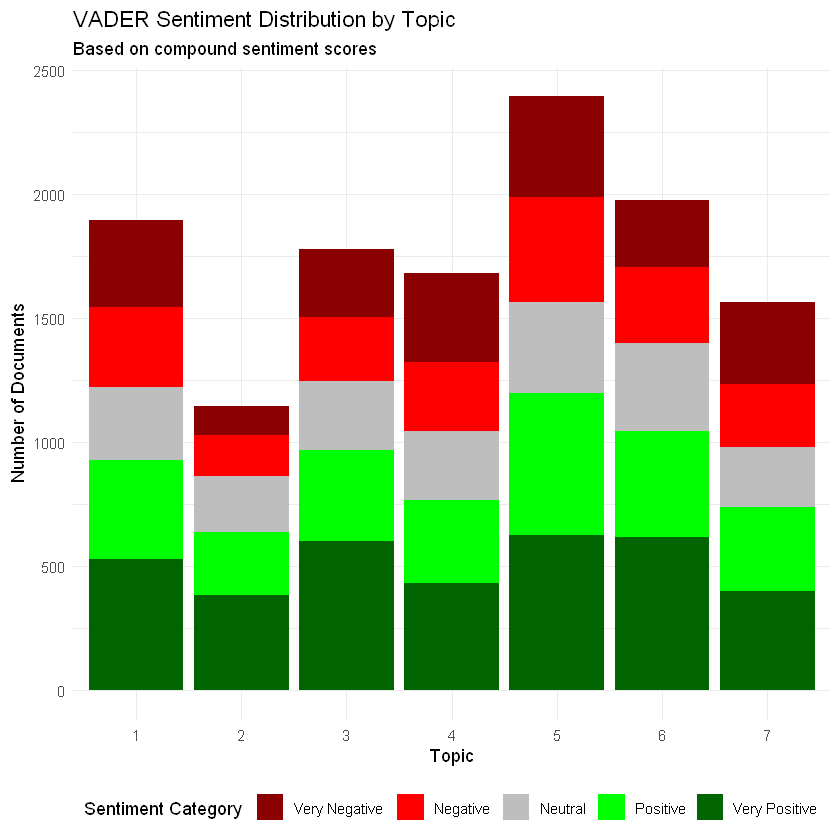

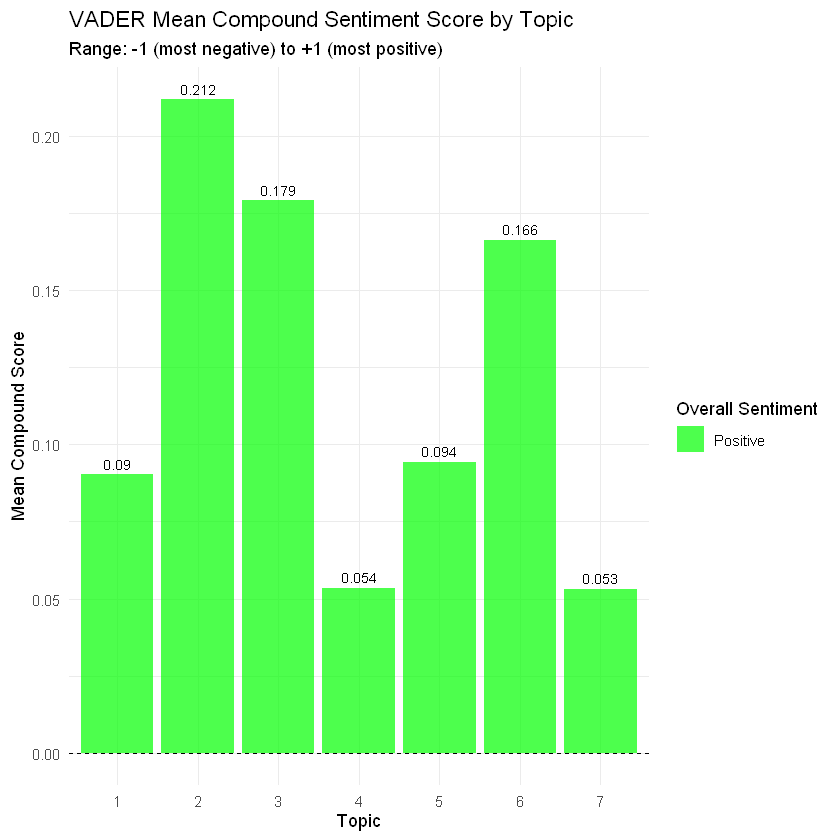

In [18]:
# Visualize VADER sentiment distribution by topic
vader_plot_data <- vader_by_topic %>%
  select(topic, very_positive, positive_docs, neutral_docs, negative_docs, very_negative) %>%
  pivot_longer(cols = -topic, names_to = "sentiment_category", values_to = "count") %>%
  mutate(
    sentiment_category = factor(sentiment_category, 
                               levels = c("very_negative", "negative_docs", "neutral_docs", 
                                        "positive_docs", "very_positive"),
                               labels = c("Very Negative", "Negative", "Neutral", 
                                        "Positive", "Very Positive"))
  )

# Stacked bar chart for VADER sentiment distribution
ggplot(vader_plot_data, aes(x = factor(topic), y = count, fill = sentiment_category)) +
  geom_col(position = "stack") +
  scale_fill_manual(values = c("darkred", "red", "gray", "green", "darkgreen")) +
  labs(title = "VADER Sentiment Distribution by Topic",
       subtitle = "Based on compound sentiment scores",
       x = "Topic",
       y = "Number of Documents",
       fill = "Sentiment Category") +
  theme_minimal() +
  theme(legend.position = "bottom")


# VADER compound score by topic
ggplot(vader_by_topic, aes(x = factor(topic), y = mean_compound)) +
  geom_col(aes(fill = mean_compound > 0), alpha = 0.7) +
  scale_fill_manual(values = c("red", "green"), 
                    labels = c("Negative", "Positive"),
                    name = "Overall Sentiment",
                    breaks = c(FALSE, TRUE)) +
  geom_hline(yintercept = 0, color = "black", linetype = "dashed") +
  geom_text(aes(label = round(mean_compound, 3)), vjust = -0.5, size = 3) +
  labs(title = "VADER Mean Compound Sentiment Score by Topic",
       subtitle = "Range: -1 (most negative) to +1 (most positive)",
       x = "Topic",
       y = "Mean Compound Score") +
  theme_minimal()


Unlike with the Bing and AFINN lexicons, we observe positive overall sentiments in all topics with VADER.

The difference can be explained by the fact that Bing and AFINN are word-level lexicon methods, whereas VADER is a rule-based sentiment analyzer, which takes into account more context. For example, when negative words are used in a positive context, as in "not bad", Bing and AFINN would incorrectly detect negative sentiment as they would consider "bad" as a negative word. However, VADER is able to detect this and correctly detect a more positive sentiment.

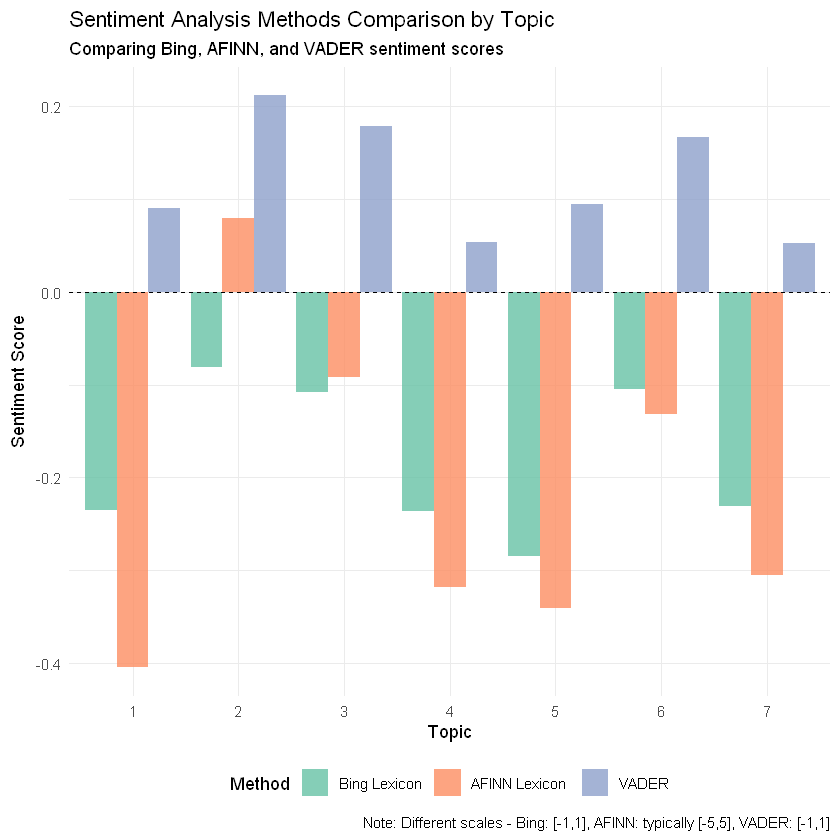

In [19]:
# Create comparison plot of all three sentiment methods
sentiment_summary <- sentiment_by_topic %>%
  left_join(afinn_by_topic, by = "topic") %>%
  select(topic, positive, negative, sentiment_score, mean_sentiment, median_sentiment, total_words)


# Update sentiment summary to include VADER results
sentiment_summary_with_vader <- sentiment_summary %>%
  left_join(vader_by_topic, by = "topic")


# Prepare data for comparison plot
comparison_data <- sentiment_summary_with_vader %>%
  select(topic, 
         bing_score = sentiment_score,
         afinn_score = mean_sentiment,
         vader_score = mean_compound) %>%
  pivot_longer(cols = c(bing_score, afinn_score, vader_score), 
               names_to = "method", values_to = "score") %>%
  mutate(
    method = factor(method, 
                   levels = c("bing_score", "afinn_score", "vader_score"),
                   labels = c("Bing Lexicon", "AFINN Lexicon", "VADER"))
  )

# Create comparison plot
ggplot(comparison_data, aes(x = factor(topic), y = score, fill = method)) +
  geom_col(position = "dodge", alpha = 0.8) +
  geom_hline(yintercept = 0, color = "black", linetype = "dashed") +
  scale_fill_brewer(type = "qual", palette = "Set2") +
  labs(title = "Sentiment Analysis Methods Comparison by Topic",
       subtitle = "Comparing Bing, AFINN, and VADER sentiment scores",
       x = "Topic",
       y = "Sentiment Score",
       fill = "Method",
       caption = "Note: Different scales - Bing: [-1,1], AFINN: typically [-5,5], VADER: [-1,1]") +
  theme_minimal() +
  theme(legend.position = "bottom")


## Named Entity Recognition (NER)

Named Entity Recognition identifies and classifies real-world entities in text such as:
- **PERSON**: Names of people
- **ORG**: Organizations, companies, agencies
- **GPE**: Geopolitical entities (countries, cities, states)
- **LOC**: Locations (mountains, bodies of water)
- **PRODUCT**: Products, software, technologies
- **EVENT**: Named events, battles, sports events

We use **spaCy's** pre-trained English model to extract entities from each document and analyze their distribution across topics. This helps identify what organizations, people, and technologies are most discussed within each thematic area.

In [25]:
suppressWarnings({
# Install and initialize spacyr
if (!requireNamespace("spacyr", quietly = TRUE)) {
  install.packages("spacyr")
}

library(spacyr)

# Initialize spaCy
spacy_initialize(model = "en_core_web_sm", ask = FALSE)

# Prepare data for NER
documents_for_ner <- all_documents %>%
  left_join(doc_topic_assignments, by = c("document_id" = "document")) %>%
  filter(!is.na(topic) & !is.na(text) & text != "") %>%
  select(doc_id = document_id, text, topic) # spacy_parse expects 'doc_id' and 'text'

# Ensure text is character type
documents_for_ner$text <- as.character(documents_for_ner$text)

# Perform NER parsing
parsed_entities <- spacy_parse(documents_for_ner, entity = TRUE, lemma = FALSE, pos = FALSE)})


successfully initialized (spaCy Version: 3.8.7, language model: en_core_web_sm)



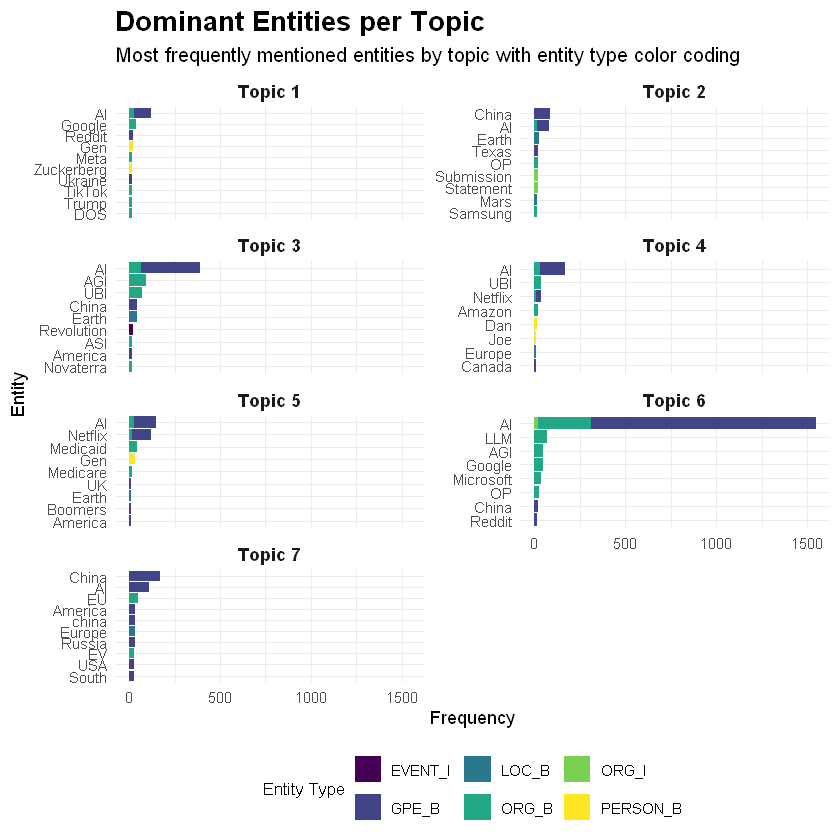

In [21]:
# Filter for actual entities and get entity text
# Create a list of words to exclude (common words, articles, etc.)
excluded_words <- c("the", "a", "an", "and", "or", "but", "in", "on", "at", "to", "for", 
                   "of", "with", "by", "from", "as", "is", "was", "are", "were", "be", 
                   "been", "being", "have", "has", "had", "do", "does", "did", "will", 
                   "would", "could", "should", "may", "might", "can", "must", "shall",
                   "this", "that", "these", "those", "i", "you", "he", "she", "it", 
                   "we", "they", "me", "him", "her", "us", "them", "my", "your", 
                   "his", "her", "its", "our", "their", "myself", "yourself", "himself",
                   "herself", "itself", "ourselves", "yourselves", "themselves")

entities_by_doc <- parsed_entities %>%
  filter(entity != "") %>% # Keep only actual entities (use 'entity' column)
  select(doc_id, entity_text = token, entity_type = entity) %>%
  # Filter out common words, very short entities, and entities that are just numbers/symbols
  filter(
    !tolower(entity_text) %in% excluded_words,  # Remove common words
    nchar(entity_text) >= 2,                    # Remove single characters
    !grepl("^[0-9]+$", entity_text),           # Remove pure numbers
    !grepl("^[[:punct:]]+$", entity_text),     # Remove pure punctuation
    !entity_text %in% c("%", "$", "€", "£"),   # Remove currency/percent symbols
    # Keep only meaningful entity types (exclude some spaCy noise)
    entity_type %in% c("PERSON", "ORG", "GPE", "LOC", "EVENT", "FAC", "PRODUCT", 
                      "WORK_OF_ART", "LAW", "LANGUAGE", "NORP", "MONEY", "PERCENT",
                      "ORG_B", "ORG_I", "GPE_B", "GPE_I", "PERSON_B", "PERSON_I",
                      "LOC_B", "LOC_I", "PRODUCT_B", "PRODUCT_I", "EVENT_B", "EVENT_I")
  )

# Join with topic information
entities_with_topics <- entities_by_doc %>%
  left_join(distinct(documents_for_ner, doc_id, topic), by = "doc_id") %>%
  filter(!is.na(topic))

# Most frequent entities per topic (this is what "dominant entities" means)
dominant_entities_per_topic <- entities_with_topics %>%
  count(topic, entity_text, entity_type, sort = TRUE) %>%
  group_by(topic) %>%
  slice_max(n, n = 10) %>%
  ungroup() %>%
  arrange(topic, -n)

ggplot(dominant_entities_per_topic, 
                                aes(x = reorder_within(entity_text, n, topic), 
                                    y = n, 
                                    fill = entity_type)) +
  geom_col() +
  facet_wrap(~ paste("Topic", topic), scales = "free_y", ncol = 2) +
  coord_flip() +
  scale_x_reordered() +
  scale_fill_viridis_d(name = "Entity Type") +
  labs(title = "Dominant Entities per Topic",
       subtitle = "Most frequently mentioned entities by topic with entity type color coding",
       x = "Entity",
       y = "Frequency") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 16, face = "bold"),
    plot.subtitle = element_text(size = 12),
    strip.text = element_text(size = 11, face = "bold"),
    axis.text.y = element_text(size = 9),
    axis.text.x = element_text(size = 9),
    legend.position = "bottom",
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 9)
  )

spacy_finalize()

Some entity types are described as follows:

- **EVENT** : Events
- **LOC** : Locations
- **ORG** : Organizations
- **GPE** : Geopolitical Entities
- **PERSON** : Person

We see that AI shows up in all the topics as a dominant entity. It is recognized as either an organization or a geopolitical entity. This might be because its capitalized acronym form resembles known entities of these types.

Of all the topics, we see that the dominant entities identified for topics 1, 6, and 7 are most conisistent with the interpretations we made about the topics earlier. 

**Topic 1: Digital Access & Information**
**Top entities:** AI, Google, Reddit, Gen, Meta, Zuckerberg, Ukraine, TikTok, Trump, DoS

**Topic 6: AI Tools & Models**
**Top entities:** AI, LLM, AGI, Google, Microsoft, OP, China, Reddit

**Topic 7: Geopolitics & Global Issues**
**Top entities:** China, EU, America, Europe, Russia, USA, South
\newpage

# Future Direction and Improvements

- Incorporate n-gram (bigram, trigram) analyses for better results with the Bing and AFINN lexicons.
- Experiment with transformer models for sentiment analysis, which has become the state-of-the-art approach.
- Explore trends across time instead of a static analysis.
- Consider relationships between posts and comments. The current analysis treats each post and comment as an individual document.
- Gather sentiments towards recognized entities 
\newpage

# References

Here are some papers on some of the techniques used in this analysis

**Tidy text analysis**

- Silge, J. & Robinson, D. (2016). “tidytext: Text Mining Using dplyr, ggplot2, and Other Tidy Tools.” Journal of Open Source Software.

**Topic modelling with LDA**

- Blei, D. M., Ng, A. Y. & Jordan, M. I. (2003). “Latent Dirichlet Allocation.” Journal of Machine Learning Research 3.

**Evaluating LDA models / picking K**

- Newman, D. et al. (2010). “Automatic Evaluation of Topic Coherence.” HLT–NAACL 2010.
- Arun, R. et al. (2010). “On Finding the Natural Number of Topics with Latent Dirichlet Allocation.” In PAKDD 2010 Workshops.

**Sentiment Analysis**

- Nielsen, F. Å. (2011). “A New ANEW: Evaluation of a Word List for Sentiment Analysis in Microblogs.” In Nordisk Sprogteknologi 2011.
- Hu, M. & Liu, B. (2004). “Mining and Summarizing Customer Reviews.” KDD 2004.
- Hutto, C. J. & Gilbert, E. (2014). “VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text.” ICWSM 2014.

**NER**

- Honnibal, M. & Montani, I. (2017). “spaCy 2: Natural Language Understanding with Bloom Embeddings.” To appear in ACL-demo (preprint)
